# Домашнее задание № 8

## Задание 1 (4 балла)

Обучите 8 моделей для задачи классификации текста (датасет - lenta_40k ). А именно:  
1) модель с 1 GRU слоем;   
2) модель с 1 LSTM слоем    
3) модель с 1 GRU и 1 LSTM слоем  
4) модель с 1 BIGRU и 2 LSTM слоями  
5) модель с 5 GRU слоями и 3 LSTM слоями  
6) модель 1 BIGRU и 1 BILSTM слоями, причем так чтобы модели для forward и backward прохода отличались   
7) модель, где последовательно идут слои: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM  



Параметр units и размер эмбединга можете задать любой. Оцените качество каждой модели и определите победителя.

In [22]:
import tensorflow as tf
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
from IPython.display import Image
from IPython.core.display import HTML
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
from sklearn.metrics import classification_report

In [77]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [78]:
data = pd.read_csv('/content/drive/MyDrive/lenta_40k.csv.zip')

In [79]:
data.head(5)

,text,topic
0,Россия должна сотрудничать с Всемирным антидоп...,Спорт
1,Уголовный суд Кувейта 28 июня освободил под за...,Мир
2,Французский журнал Charlie Hebdo опубликовал н...,Интернет и СМИ
3,В Петербурге в доме № 53 по улице Лени Голиков...,Россия
4,"В московском аэропорту ""Домодедово"" задержан г...",Россия


In [80]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [token for token in tokens if token]
    return tokens

In [81]:
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [82]:
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

len(filtered_vocab)

24090

In [83]:
word2id = {'PAD':0, 'UNK':1}

for word in filtered_vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

In [84]:
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

MAX_LEN = max(len(x) for x in X)

In [85]:
MEAN_LEN = np.median([len(x) for x in X])

MAX_LEN, MEAN_LEN

(1732, 169.0)

In [86]:
MAX_LEN = int(MEAN_LEN + 31)

In [87]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [88]:
X.shape

(44356, 200)

In [89]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [90]:
y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [91]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

### 1) Модель с 1 GRU слоем

In [ ]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs)

gru = tf.keras.layers.GRU(128, return_sequences=False)(embeddings)

dense = keras.layers.Dense(60, activation='relu')(gru)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense)


model_1gru = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_1gru.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [ ]:
model_1gru.fit(X_train, y_train, validation_data=(X_valid, y_valid),batch_size=1000, epochs=20)

Epoch 1/20
43/43 [==============================] - 101s 2s/step - loss: 2.5792 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3388 - val_f1: 0.0000e+00 - val_rec@prec: 9.0171e-04
Epoch 2/20
43/43 [==============================] - 96s 2s/step - loss: 2.2823 - f1: 0.0000e+00 - rec@prec: 3.7970e-04 - val_loss: 2.2356 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 3/20
43/43 [==============================] - 95s 2s/step - loss: 2.0801 - f1: 0.0140 - rec@prec: 1.1866e-04 - val_loss: 2.1742 - val_f1: 6.6600e-04 - val_rec@prec: 0.0023
Epoch 4/20
43/43 [==============================] - 95s 2s/step - loss: 1.9187 - f1: 0.0557 - rec@prec: 0.0034 - val_loss: 1.8806 - val_f1: 0.0376 - val_rec@prec: 0.0018
Epoch 5/20
43/43 [==============================] - 96s 2s/step - loss: 1.6521 - f1: 0.1646 - rec@prec: 0.0630 - val_loss: 1.7903 - val_f1: 0.2075 - val_rec@prec: 0.0924
Epoch 6/20
43/43 [==============================] - 95s 2s/step - loss: 1.4589 - f1: 0.3514 - rec@prec: 0.198

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


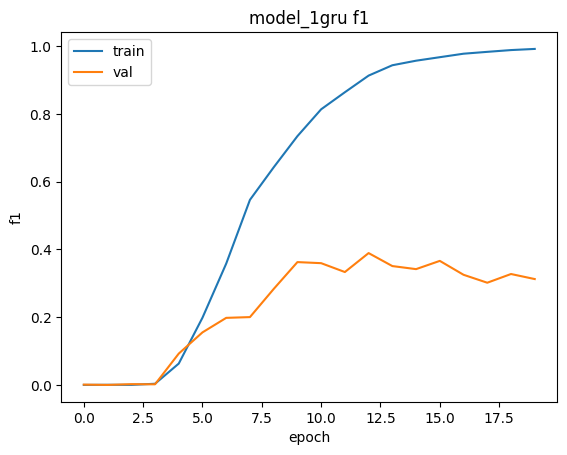

In [ ]:
print(model_1gru.history.history.keys())
# summarize history for accuracy
plt.plot(model_1gru.history.history['rec@prec'])
plt.plot(model_1gru.history.history['val_rec@prec'])
plt.title('model_1gru f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Данная модель продемонстироровала следующие характериситики: loss: 0.1197 и val_loss: 3.0978, f1: 0.9753 и val_f1: 0.5551.

Хотя она показывает довольно скромные метрики (и поэтому не может быть названа победителем), её большой плюс заключается в приемлемой скорости обучения при условиях ограниченного доступа к GPU от Google.
Это положительное качество, которое постепенно будут терять модели по ходу этого задания. 

### 2) Модель с 1 LSTM слоем

In [ ]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs)

lstm = tf.keras.layers.LSTM(128, return_sequences=False)(embeddings)


dense = keras.layers.Dense(60, activation='relu')(lstm)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense)


model_1lstm = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_1lstm.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [ ]:
model_1lstm.fit(X_train, y_train, validation_data=(X_valid, y_valid),batch_size=1000, epochs=20)

Epoch 1/20
43/43 [==============================] - 120s 3s/step - loss: 2.5206 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3298 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/20
43/43 [==============================] - 116s 3s/step - loss: 2.2913 - f1: 0.0000e+00 - rec@prec: 9.4926e-05 - val_loss: 2.1647 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 3/20
43/43 [==============================] - 115s 3s/step - loss: 1.9321 - f1: 0.0272 - rec@prec: 0.0238 - val_loss: 2.0351 - val_f1: 0.1383 - val_rec@prec: 0.0586
Epoch 4/20
43/43 [==============================] - 118s 3s/step - loss: 1.7906 - f1: 0.1560 - rec@prec: 0.0993 - val_loss: 1.7506 - val_f1: 0.3258 - val_rec@prec: 0.1844
Epoch 5/20
43/43 [==============================] - 115s 3s/step - loss: 1.4947 - f1: 0.4480 - rec@prec: 0.2370 - val_loss: 1.4868 - val_f1: 0.5246 - val_rec@prec: 0.2741
Epoch 6/20
43/43 [==============================] - 117s 3s/step - loss: 1.2570 - f1: 0.5741 - rec@prec: 0.4032 -

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


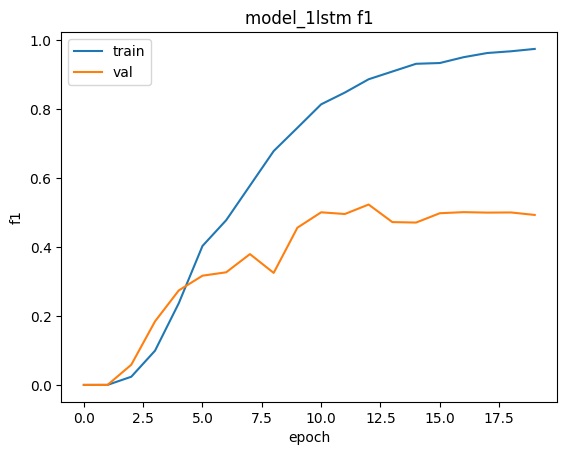

In [ ]:
print(model_1lstm.history.history.keys())
# summarize history for accuracy
plt.plot(model_1lstm.history.history['rec@prec'])
plt.plot(model_1lstm.history.history['val_rec@prec'])
plt.title('model_1lstm f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Данная модель продемонстироровала следующие характериситики: loss: 0.2281 и val_loss: 1.7073, f1: 0.9401 и val_f1: 0.6609.

Ощутимое улучшение в сравнении с предыдущей моделью. Хотя она обучалась немного дольше, её показатель val_f1 оказался гораздо выше. Это одна из немногих моделей, которая смогла приблизить его к 0,7. 

### 3) модель с 1 GRU и 1 LSTM слоем

In [ ]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs)

dense = keras.layers.Dense(60, activation='relu')(embeddings)
lstm = tf.keras.layers.LSTM(128, return_sequences=True)(dense)
gru = tf.keras.layers.GRU(128, return_sequences=False)(lstm)


outputs = keras.layers.Dense(len(label2id), activation='softmax')(gru)


model_1gru_1lstm = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_1gru_1lstm.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [ ]:
model_1gru_1lstm.fit(X_train, y_train, validation_data=(X_valid, y_valid),batch_size=1000, epochs=20)

Epoch 1/20
43/43 [==============================] - 305s 7s/step - loss: 2.4587 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3197 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/20
43/43 [==============================] - 322s 8s/step - loss: 2.2725 - f1: 0.0000e+00 - rec@prec: 1.8985e-04 - val_loss: 2.1713 - val_f1: 0.0000e+00 - val_rec@prec: 0.0036
Epoch 3/20
43/43 [==============================] - 297s 7s/step - loss: 1.9265 - f1: 0.0361 - rec@prec: 0.0000e+00 - val_loss: 1.7804 - val_f1: 0.0963 - val_rec@prec: 0.0690
Epoch 4/20
43/43 [==============================] - 290s 7s/step - loss: 1.5855 - f1: 0.2105 - rec@prec: 0.1123 - val_loss: 1.5426 - val_f1: 0.3545 - val_rec@prec: 0.1605
Epoch 5/20
43/43 [==============================] - 294s 7s/step - loss: 1.2843 - f1: 0.4996 - rec@prec: 0.3119 - val_loss: 1.3722 - val_f1: 0.5473 - val_rec@prec: 0.3264
Epoch 6/20
43/43 [==============================] - 326s 8s/step - loss: 1.0559 - f1: 0.6449 - rec@prec: 0.5122 -

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


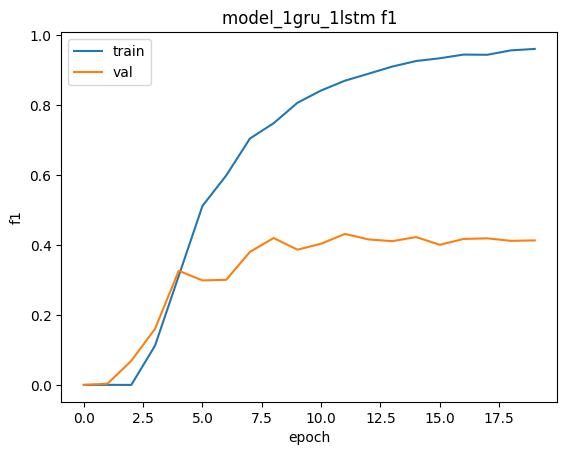

In [ ]:
print(model_1gru_1lstm.history.history.keys())
# summarize history for accuracy
plt.plot(model_1gru_1lstm.history.history['rec@prec'])
plt.plot(model_1gru_1lstm.history.history['val_rec@prec'])
plt.title('model_1gru_1lstm f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Данная модель продемонстироровала следующие характериситики: loss: 0.2884 и val_loss: 1.9846, f1: 0.9280 и val_f1: 0.5829.

Объединение GRU и LSTM слоёв не дало сильного улучшения по сравнению с предыдущей моделью. Мы видим некоторое увеличение потерь и сокращение f1.

### 4) модель с 1 BIGRU и 2 LSTM слоями

In [18]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs)

bigru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embeddings)
lstm1 = tf.keras.layers.LSTM(128, return_sequences=True)(bigru)
lstm2 = tf.keras.layers.LSTM(128, return_sequences=False)(lstm1)

dense = keras.layers.Dense(60, activation='relu')(lstm2)

outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense)


model_1bigru_1lstm = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_1bigru_1lstm.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [19]:
model_1bigru_1lstm.fit(X_train, y_train, validation_data=(X_valid, y_valid),batch_size=1000, epochs=20)

Epoch 1/20
43/43 [==============================] - 26s 354ms/step - loss: 2.4316 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3298 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/20
43/43 [==============================] - 14s 318ms/step - loss: 2.3211 - f1: 0.0000e+00 - rec@prec: 9.4926e-05 - val_loss: 2.2723 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 3/20
43/43 [==============================] - 14s 324ms/step - loss: 2.0190 - f1: 0.0243 - rec@prec: 0.0079 - val_loss: 1.8150 - val_f1: 0.1140 - val_rec@prec: 0.0654
Epoch 4/20
43/43 [==============================] - 15s 355ms/step - loss: 1.7003 - f1: 0.2355 - rec@prec: 0.1061 - val_loss: 1.7571 - val_f1: 0.2229 - val_rec@prec: 0.0816
Epoch 5/20
43/43 [==============================] - 13s 301ms/step - loss: 1.5520 - f1: 0.3674 - rec@prec: 0.1926 - val_loss: 1.6780 - val_f1: 0.4576 - val_rec@prec: 0.1546
Epoch 6/20
43/43 [==============================] - 13s 299ms/step - loss: 1.3488 - f1: 0.5460 - rec@pr

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


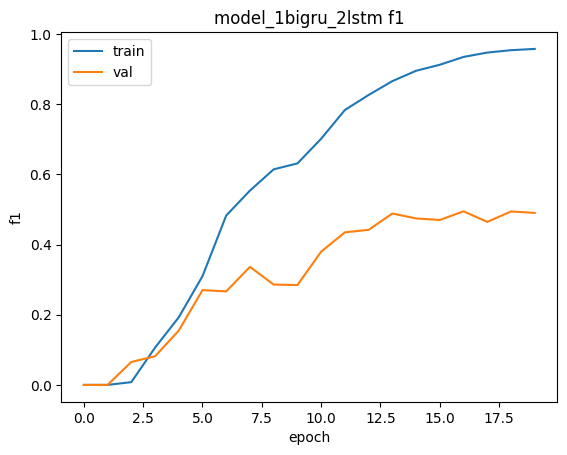

In [21]:
print(model_1bigru_1lstm.history.history.keys())
# summarize history for accuracy
plt.plot(model_1bigru_1lstm.history.history['rec@prec'])
plt.plot(model_1bigru_1lstm.history.history['val_rec@prec'])
plt.title('model_1bigru_2lstm f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Данная модель продемонстироровала следующие характериситики: loss: 0.2991 и val_loss: 1.6382, f1: 0.9214 и val_f1: 0.6518.

Это первая модель с несколькими разными слоями, которая показала неплохие (приближенные к уровням модели 2) показатели, хотя f1 оказался несколько ниже.

Интересный факт:
Изначально я допустил ошибку и обучил модель только с одним BIGRU и одним LSTM слоем. Это дало самые высокие показатели f1 из всех моделей. После добавления второго LSTM слоя показатели сильно ухудшились.
Вариант с одним BIGRU и одним LSTM слоем я попытался обучить ниже - в дополнительной модели. 

### 5) модель с 5 GRU слоями и 3 LSTM слоями

In [ ]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs)

gru1 = tf.keras.layers.GRU(40, return_sequences=True)(embeddings)
lstm1 = tf.keras.layers.LSTM(40, return_sequences=True)(gru1)
gru2 = tf.keras.layers.GRU(40, return_sequences=True)(lstm1)
lstm2 = tf.keras.layers.LSTM(40, return_sequences=True)(gru2)
gru3 = tf.keras.layers.GRU(40, return_sequences=True)(lstm2)
lstm3 = tf.keras.layers.LSTM(40, return_sequences=True)(gru3)
gru4 = tf.keras.layers.GRU(40, return_sequences=True)(lstm3)

gru5 = tf.keras.layers.GRU(40, return_sequences=False)(gru4)



outputs = keras.layers.Dense(len(label2id), activation='softmax')(gru5)


model_5gru_3lstm = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_5gru_3lstm.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [ ]:
model_5gru_3lstm.fit(X_train, y_train, validation_data=(X_valid, y_valid),batch_size=1000, epochs=15)

Epoch 1/15
43/43 [==============================] - 283s 6s/step - loss: 2.4977 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3310 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/15
43/43 [==============================] - 290s 7s/step - loss: 2.3284 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3238 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 3/15
43/43 [==============================] - 290s 7s/step - loss: 2.3239 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3209 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 4/15
43/43 [==============================] - 291s 7s/step - loss: 2.3233 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3227 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 5/15
43/43 [==============================] - 294s 7s/step - loss: 2.3231 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3204 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 6/15
43/43 [==============================] - 285s 7s/step 

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


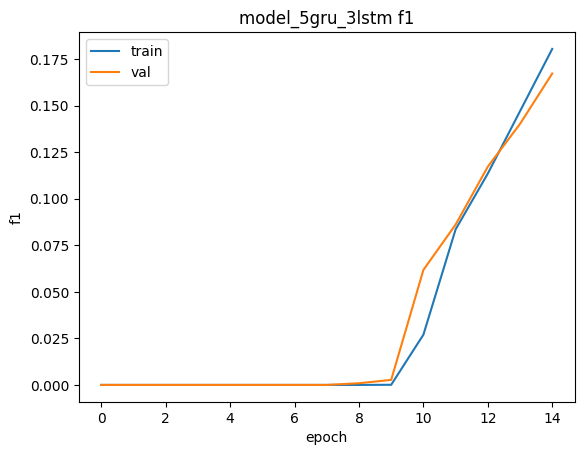

In [ ]:
print(model_5gru_3lstm.history.history.keys())
# summarize history for accuracy
plt.plot(model_5gru_3lstm.history.history['rec@prec'])
plt.plot(model_5gru_3lstm.history.history['val_rec@prec'])
plt.title('model_5gru_3lstm f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Данная модель продемонстироровала следующие характериситики: loss: 1.3509 и val_loss: 1.6625, f1: 0.3549 и val_f1: 0.3792.

Это первая модель которая несколько раз приводила к вылету ядра. Единственным способом этого избежать было сокращение числа юнитов во всех слоях до 40. Это оптимальное значение. Стопроцентные вылеты начинались где-то с 60, диапазон 40-60 оказывалася своеобразной серой зоной, в которой ядро могло вылететь в любой непредсказуемый момент - даже спустя полчаса обучения.

В любом случае, модель дала одни из самых худших показателей f1 среди всех обученных.

### 6) модель 1 BIGRU и 1 BILSTM слоями

In [ ]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs)


hidden = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=False),
                         backward_layer=tf.keras.layers.LSTM(128, return_sequences=False, go_backwards=True))(embeddings)

outputs = keras.layers.Dense(len(label2id), activation='softmax')(hidden)


model_1bigru_1bilstm = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_1bigru_1bilstm.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [ ]:
model_1bigru_1bilstm.fit(X_train, y_train, validation_data=(X_valid, y_valid),batch_size=2000, epochs=20)

Epoch 1/20
22/22 [==============================] - 206s 9s/step - loss: 2.2657 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.2724 - val_f1: 0.0000e+00 - val_rec@prec: 9.0171e-04
Epoch 2/20
22/22 [==============================] - 201s 9s/step - loss: 2.1301 - f1: 0.0285 - rec@prec: 0.0152 - val_loss: 1.9092 - val_f1: 0.1662 - val_rec@prec: 0.0960
Epoch 3/20
22/22 [==============================] - 201s 9s/step - loss: 1.6860 - f1: 0.2924 - rec@prec: 0.1155 - val_loss: 1.6594 - val_f1: 0.3168 - val_rec@prec: 0.1488
Epoch 4/20
22/22 [==============================] - 201s 9s/step - loss: 1.4601 - f1: 0.4561 - rec@prec: 0.2848 - val_loss: 1.5135 - val_f1: 0.4334 - val_rec@prec: 0.2074
Epoch 5/20
22/22 [==============================] - 201s 9s/step - loss: 1.2919 - f1: 0.5594 - rec@prec: 0.4166 - val_loss: 1.4504 - val_f1: 0.4782 - val_rec@prec: 0.2349
Epoch 6/20
22/22 [==============================] - 202s 9s/step - loss: 1.1696 - f1: 0.6125 - rec@prec: 0.4965 - val_loss: 1.424

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


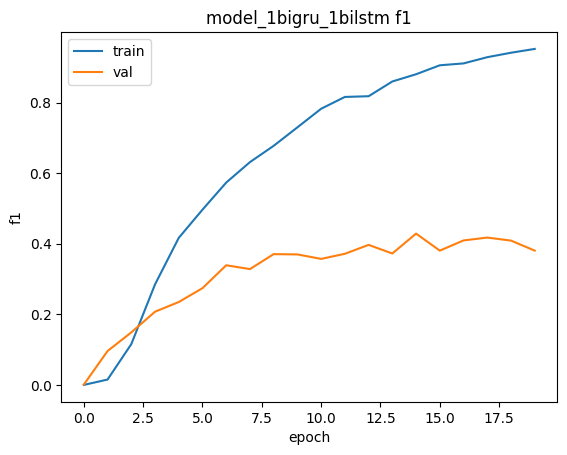

In [ ]:
print(model_1bigru_1bilstm.history.history.keys())
# summarize history for accuracy
plt.plot(model_1bigru_1bilstm.history.history['rec@prec'])
plt.plot(model_1bigru_1bilstm.history.history['val_rec@prec'])
plt.title('model_1bigru_1bilstm f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Данная модель продемонстироровала следующие характериситики: loss: 0.3329 и val_loss: 1.8575, f1: 0.9112 и val_f1: 0.6008.

По качеству результатов эта модель недалеко ушла от самой первой модели в данном задании. Тем не менее, обучается она гораздо дольше. 

### 7) модель, где последовательно идут слои: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM

In [ ]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs)

lstm = tf.keras.layers.LSTM(30, return_sequences=True)(embeddings)
gru = tf.keras.layers.GRU(30, return_sequences=True)(lstm)
bilstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(30, return_sequences=True))(gru)
bigru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(30, return_sequences=True))(bilstm)
gru2 = tf.keras.layers.GRU(30, return_sequences=True)(bigru)
lstm2 = tf.keras.layers.LSTM(30, return_sequences=False)(gru2)

outputs = keras.layers.Dense(len(label2id), activation='softmax')(lstm2)


model_final = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_final.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [ ]:
model_final.fit(X_train, y_train, validation_data=(X_valid, y_valid),batch_size=3000, epochs=15)

Epoch 1/15
15/15 [==============================] - 222s 13s/step - loss: 2.8488 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.5669 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/15
15/15 [==============================] - 197s 13s/step - loss: 2.4816 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.4130 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 3/15
15/15 [==============================] - 202s 13s/step - loss: 2.3849 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3576 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 4/15
15/15 [==============================] - 198s 13s/step - loss: 2.3473 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3355 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 5/15
15/15 [==============================] - 197s 13s/step - loss: 2.3332 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3290 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 6/15
15/15 [==============================] - 200s 13s

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


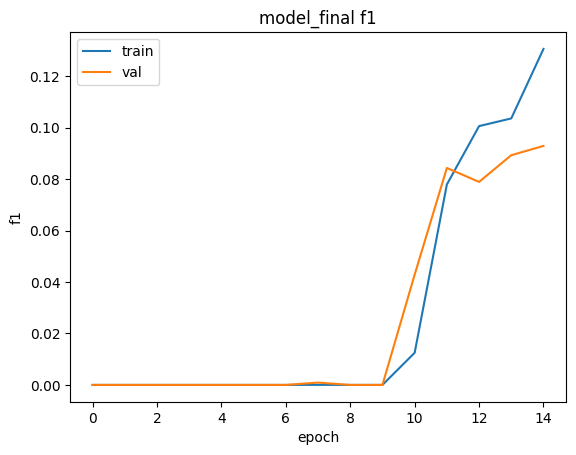

In [ ]:
print(model_final.history.history.keys())
# summarize history for accuracy
plt.plot(model_final.history.history['rec@prec'])
plt.plot(model_final.history.history['val_rec@prec'])
plt.title('model_final f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Данная модель продемонстироровала следующие характериситики: loss: 1.5250 и val_loss: 1.7010, f1: 0.2740 и val_f1: 0.3280.

Ещё одна модель, которая не раз обрушила ядро. Обучается долго. Даёт худшие результаты по f1 и довольно посредственный loss. Не рекомендую.

### Дополнительная модель - 1 BIGRU, 1 LSTM

In [94]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs)

bigru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embeddings)
lstm = tf.keras.layers.LSTM(128, return_sequences=False)(bigru)


dense = keras.layers.Dense(60, activation='relu')(lstm)

outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense)


model_1bigrulstm = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_1bigrulstm.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [95]:
model_1bigrulstm.fit(X_train, y_train, validation_data=(X_valid, y_valid),batch_size=1000, epochs=20)

Epoch 1/20
43/43 [==============================] - 518s 12s/step - loss: 2.4770 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3234 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/20
43/43 [==============================] - 496s 11s/step - loss: 2.2055 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.0366 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 3/20
43/43 [==============================] - 497s 12s/step - loss: 1.8080 - f1: 0.1096 - rec@prec: 0.0441 - val_loss: 1.6692 - val_f1: 0.4144 - val_rec@prec: 0.1168
Epoch 4/20
43/43 [==============================] - 501s 12s/step - loss: 1.4470 - f1: 0.4768 - rec@prec: 0.2394 - val_loss: 1.5103 - val_f1: 0.4876 - val_rec@prec: 0.2182
Epoch 5/20
43/43 [==============================] - 501s 12s/step - loss: 1.2239 - f1: 0.5833 - rec@prec: 0.3483 - val_loss: 1.4870 - val_f1: 0.5371 - val_rec@prec: 0.2164
Epoch 6/20
43/43 [==============================] - 505s 12s/step - loss: 1.1229 - f1: 0.6334 - rec@prec: 0.

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


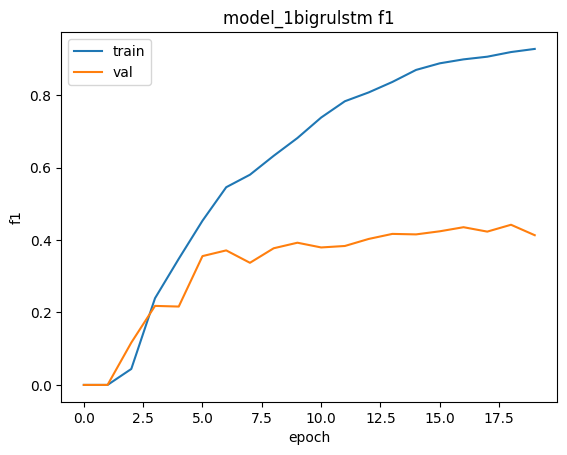

In [96]:
print(model_1bigrulstm.history.history.keys())
# summarize history for accuracy
plt.plot(model_1bigrulstm.history.history['rec@prec'])
plt.plot(model_1bigrulstm.history.history['val_rec@prec'])
plt.title('model_1bigrulstm f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Данная модель продемонстироровала следующие характериситики: loss: 0.4130 и val_loss: 1.6497, f1: 0.8940 и val_f1: 0.6340.

При первоначальных тестах эта модель смогла показать самые высокие показатели val_f1 - выше 0,9. А также очень качественные значения loss. К сожалению, повторить эти же метрики не получилось - результаты выше в сравнении с остальными моделями довольно посредственны. 

## Вывод:

Победителем в данном задании можно назвать 2) Модель с 1 LSTM слоем. Она показала самые выскоие показатели f1 довольно небольшой loss. 
Также неплохие метрики продемонстрировала 4) модель с 1 BIGRU и 2 LSTM слоями. Это единственная модель с несколькмим слоями, которая добилась f1_val на уровне 0,65. Тем не менее, её метрики ниже второй модели, и обучалась она гораздо дольше. 

## Задание 2 (6 баллов)


На данных википедии (wikiann) обучите 2 модели:  
1) модель в которой будут использованы предобученные эмбединги слов и несколько BILSTM слоев.
1) модель в которой будут использованы предобученные эмбединги слов и несколько BIGRU слоев.

Сравните качество по метрикам. Также придумайте несколько сложных примеров и проверьте, какие сущности определяет каждая из моделей.

In [3]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.5 MB/s eta 0:00:00


In [4]:
from datasets import load_dataset

In [5]:
dataset = load_dataset("wikiann", 'ru')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [6]:
vocab = Counter()

for sent in dataset['train']['tokens']:
    vocab.update([x.lower() for x in sent])

In [7]:
word2id = {'PAD':0, 'UNK':1}

for word in vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

In [8]:
X = []

for sent in dataset['train']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [10]:
X_test = []

for sent in dataset['test']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X_test.append(ids)

In [11]:
MAX_LEN = max(len(x) for x in X)

In [12]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN, padding='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_LEN, padding='post')

In [13]:
id2labels = {0:'O', 1:'B-PER', 2:'I-PER', 3:'B-ORG', 4:'I-ORG', 5: 'B-LOC', 6:'I-LOC', 7:'PAD'}
label2id = {v:k for k,v in id2labels.items()}

In [14]:
y = tf.keras.preprocessing.sequence.pad_sequences(dataset['train']['ner_tags'], value=7, maxlen=MAX_LEN,  padding='post')
y_test = tf.keras.preprocessing.sequence.pad_sequences(dataset['test']['ner_tags'], value=7, maxlen=MAX_LEN,  padding='post')

### 1) модель в которой будут использованы предобученные эмбединги слов и несколько BILSTM слоев.

In [18]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=130)(inputs)

lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embeddings)
lstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(lstm1)
lstm3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(lstm2)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm3)

model_3bilstm = tf.keras.Model(inputs=inputs, outputs=outputs)
model_3bilstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [19]:
model_3bilstm.fit(X, y, validation_data=(X_test, y_test), batch_size=128, epochs=5)

Epoch 1/5
157/157 [==============================] - 275s 2s/step - loss: 0.2298 - accuracy: 0.9335 - val_loss: 0.1479 - val_accuracy: 0.9537
Epoch 2/5
157/157 [==============================] - 295s 2s/step - loss: 0.1278 - accuracy: 0.9594 - val_loss: 0.1125 - val_accuracy: 0.9636
Epoch 3/5
157/157 [==============================] - 270s 2s/step - loss: 0.0866 - accuracy: 0.9715 - val_loss: 0.0864 - val_accuracy: 0.9728
Epoch 4/5
157/157 [==============================] - 261s 2s/step - loss: 0.0477 - accuracy: 0.9849 - val_loss: 0.0627 - val_accuracy: 0.9804
Epoch 5/5
157/157 [==============================] - 254s 2s/step - loss: 0.0192 - accuracy: 0.9944 - val_loss: 0.0587 - val_accuracy: 0.9838


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


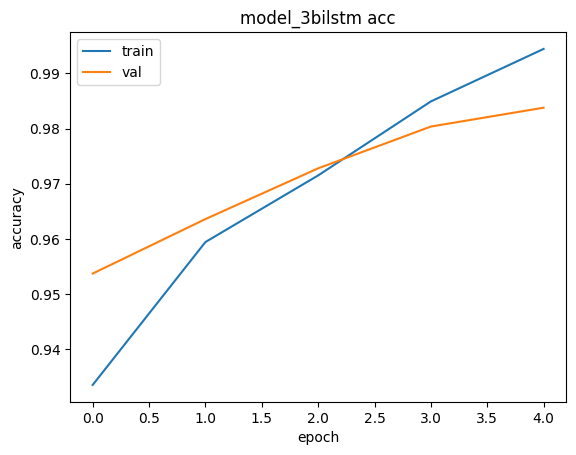

In [21]:
print(model_3bilstm.history.history.keys())
plt.plot(model_3bilstm.history.history['accuracy'])
plt.plot(model_3bilstm.history.history['val_accuracy'])
plt.title('model_3bilstm acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [31]:
pred = model_3bilstm.predict(X_test).argmax(2)

313/313 [==============================] - 66s 212ms/step


In [32]:
print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2labels.keys()), target_names=list(id2labels.values()),
                                                                     zero_division=0))

              precision    recall  f1-score   support

           O       0.92      0.97      0.94     40480
       B-PER       0.89      0.77      0.83      3542
       I-PER       0.95      0.84      0.89      7544
       B-ORG       0.64      0.71      0.67      4074
       I-ORG       0.84      0.78      0.81      8008
       B-LOC       0.75      0.62      0.68      4560
       I-LOC       0.75      0.68      0.71      3060
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.98    540000
   macro avg       0.84      0.80      0.82    540000
weighted avg       0.98      0.98      0.98    540000



### 2) модель в которой будут использованы предобученные эмбединги слов и несколько BIGRU слоев.

In [25]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=130)(inputs)

gru1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embeddings)
gru2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(gru1)
gru3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(gru2)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(gru3)

model_3bigru = tf.keras.Model(inputs=inputs, outputs=outputs)
model_3bigru.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [26]:
model_3bigru.fit(X, y, validation_data=(X_test, y_test), batch_size=128, epochs=5)

Epoch 1/5
157/157 [==============================] - 260s 2s/step - loss: 0.2318 - accuracy: 0.9335 - val_loss: 0.1357 - val_accuracy: 0.9569
Epoch 2/5
157/157 [==============================] - 280s 2s/step - loss: 0.1038 - accuracy: 0.9668 - val_loss: 0.0775 - val_accuracy: 0.9760
Epoch 3/5
157/157 [==============================] - 248s 2s/step - loss: 0.0411 - accuracy: 0.9870 - val_loss: 0.0487 - val_accuracy: 0.9848
Epoch 4/5
157/157 [==============================] - 245s 2s/step - loss: 0.0144 - accuracy: 0.9958 - val_loss: 0.0519 - val_accuracy: 0.9846
Epoch 5/5
157/157 [==============================] - 246s 2s/step - loss: 0.0074 - accuracy: 0.9980 - val_loss: 0.0583 - val_accuracy: 0.9844


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


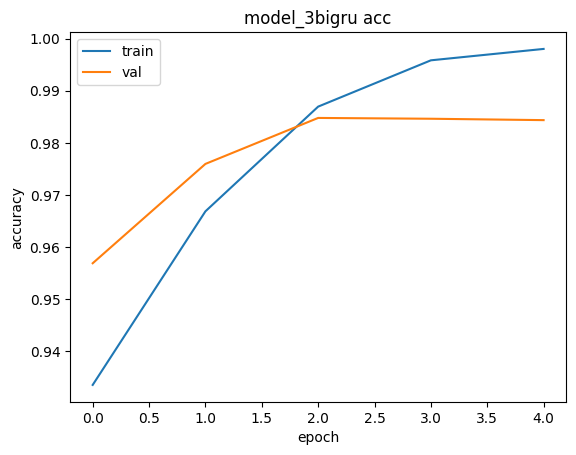

In [27]:
print(model_3bigru.history.history.keys())
plt.plot(model_3bigru.history.history['accuracy'])
plt.plot(model_3bigru.history.history['val_accuracy'])
plt.title('model_3bigru acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [29]:
pred2 = model_3bigru.predict(X_test).argmax(2)

313/313 [==============================] - 72s 213ms/step


In [30]:
print(classification_report(y_test.reshape(-1), pred2.reshape(-1), labels=list(id2labels.keys()), target_names=list(id2labels.values()),
                                                                     zero_division=0))

              precision    recall  f1-score   support

           O       0.94      0.95      0.94     40480
       B-PER       0.92      0.82      0.87      3542
       I-PER       0.96      0.86      0.91      7544
       B-ORG       0.54      0.82      0.65      4074
       I-ORG       0.79      0.82      0.80      8008
       B-LOC       0.81      0.71      0.75      4560
       I-LOC       0.94      0.66      0.78      3060
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.98    540000
   macro avg       0.86      0.83      0.84    540000
weighted avg       0.99      0.98      0.98    540000



## Оценка
Модель с насколькими BIGRU слоями показывает чуть более высокие результаты по всем показателям, хотя обобщённый f1-score у обеих моделей почти идентичный.

## Проверка на примерах

In [33]:
import re

def tokenize(text, word2id):
    # токенизирует и переводит в индексы
    tokens = re.findall('\w+|[^\w\s]+', text)
    ids = [word2id.get(token.lower(), 1) for token in tokens]
    return tokens, ids

def pred2tags(pred, id2label, length):
    # декодирует индексы в части речи
    # length нужно чтобы откидывать паддинги или некорректные предсказания
    pred = pred.argmax(2)[0, :length]
    labels = [id2label[l] for l in pred]
    return labels

def label_seq(text, word2id, id2label, max_len, model):
    tokens, ids = tokenize(text, word2id)
    pred = model.predict(tf.keras.preprocessing.sequence.pad_sequences([ids],
                                                                       maxlen=max_len,
                                                                       padding='post'))
    labels = pred2tags(pred, id2label, len(ids))

    return list(zip(tokens, labels))

In [73]:
check_str1 = "Google не дает Алексею использовать свою GPU и просит за это доллары США, Алексей очень грустит"
check_str2 = "головы пяти собак — Конана, Милтона, Мюррея, Роберта и Лукаса — мастифов, которых Миллей называл своими четвероногими детьми"
check_str3 = "Федеральное министерство возглавляется входящим в состав Правительства Российской Федерации министром Российской Федерации"
check_str4 = "Пётр, Мария и Светлана решили, что напишут все рефераты за неделю, в следующем семестре мы не увидели Петра, Марии и Светланы"
check_str5 = "Женя и Лера уехали в Армению"


### 1) BILSTM

In [61]:
label_seq(check_str1, word2id, id2labels, MAX_LEN, model_3bilstm)

1/1 [==============================] - 0s 62ms/step


[('Google', 'O'),
 ('не', 'O'),
 ('дает', 'O'),
 ('Алексею', 'O'),
 ('использовать', 'O'),
 ('свою', 'O'),
 ('GPU', 'O'),
 ('и', 'O'),
 ('просит', 'O'),
 ('за', 'O'),
 ('это', 'O'),
 ('доллары', 'B-LOC'),
 ('США', 'I-LOC'),
 (',', 'O'),
 ('Алексей', 'B-PER'),
 ('очень', 'O'),
 ('грустит', 'O')]

In [62]:
label_seq(check_str2, word2id, id2labels, MAX_LEN, model_3bilstm)

1/1 [==============================] - 0s 68ms/step


[('головы', 'O'),
 ('пяти', 'O'),
 ('собак', 'O'),
 ('—', 'O'),
 ('Конана', 'O'),
 (',', 'O'),
 ('Милтона', 'O'),
 (',', 'O'),
 ('Мюррея', 'O'),
 (',', 'O'),
 ('Роберта', 'B-PER'),
 ('и', 'O'),
 ('Лукаса', 'O'),
 ('—', 'O'),
 ('мастифов', 'O'),
 (',', 'O'),
 ('которых', 'O'),
 ('Миллей', 'O'),
 ('называл', 'O'),
 ('своими', 'O'),
 ('четвероногими', 'O'),
 ('детьми', 'O')]

In [63]:
label_seq(check_str3, word2id, id2labels, MAX_LEN, model_3bilstm)

1/1 [==============================] - 0s 60ms/step


[('Федеральное', 'O'),
 ('министерство', 'I-ORG'),
 ('возглавляется', 'I-ORG'),
 ('входящим', 'O'),
 ('в', 'O'),
 ('состав', 'O'),
 ('Правительства', 'O'),
 ('Российской', 'I-ORG'),
 ('Федерации', 'I-ORG'),
 ('министром', 'I-ORG'),
 ('Российской', 'I-ORG'),
 ('Федерации', 'I-ORG')]

In [70]:
label_seq(check_str4, word2id, id2labels, MAX_LEN, model_3bilstm)

1/1 [==============================] - 0s 66ms/step


[('Пётр', 'B-PER'),
 (',', 'I-PER'),
 ('Мария', 'I-PER'),
 ('и', 'O'),
 ('Светлана', 'O'),
 ('решили', 'O'),
 (',', 'O'),
 ('что', 'O'),
 ('напишут', 'O'),
 ('все', 'O'),
 ('рефераты', 'O'),
 ('за', 'O'),
 ('неделю', 'O'),
 (',', 'O'),
 ('в', 'O'),
 ('следующем', 'O'),
 ('семестре', 'O'),
 ('мы', 'O'),
 ('не', 'O'),
 ('увидели', 'O'),
 ('Петра', 'B-PER'),
 (',', 'O'),
 ('Марии', 'B-PER'),
 ('и', 'O'),
 ('Светланы', 'O')]

In [74]:
label_seq(check_str5, word2id, id2labels, MAX_LEN, model_3bilstm)

1/1 [==============================] - 0s 126ms/step


[('Женя', 'O'),
 ('и', 'O'),
 ('Лера', 'O'),
 ('уехали', 'O'),
 ('в', 'O'),
 ('Армению', 'O')]

### 2) BIGRU

In [64]:
label_seq(check_str1, word2id, id2labels, MAX_LEN, model_3bigru)

1/1 [==============================] - 0s 54ms/step


[('Google', 'O'),
 ('не', 'O'),
 ('дает', 'O'),
 ('Алексею', 'O'),
 ('использовать', 'O'),
 ('свою', 'O'),
 ('GPU', 'O'),
 ('и', 'O'),
 ('просит', 'O'),
 ('за', 'O'),
 ('это', 'O'),
 ('доллары', 'B-ORG'),
 ('США', 'I-ORG'),
 (',', 'O'),
 ('Алексей', 'B-PER'),
 ('очень', 'O'),
 ('грустит', 'O')]

In [65]:
label_seq(check_str2, word2id, id2labels, MAX_LEN, model_3bilstm)

1/1 [==============================] - 0s 54ms/step


[('головы', 'O'),
 ('пяти', 'O'),
 ('собак', 'O'),
 ('—', 'O'),
 ('Конана', 'O'),
 (',', 'O'),
 ('Милтона', 'O'),
 (',', 'O'),
 ('Мюррея', 'O'),
 (',', 'O'),
 ('Роберта', 'B-PER'),
 ('и', 'O'),
 ('Лукаса', 'O'),
 ('—', 'O'),
 ('мастифов', 'O'),
 (',', 'O'),
 ('которых', 'O'),
 ('Миллей', 'O'),
 ('называл', 'O'),
 ('своими', 'O'),
 ('четвероногими', 'O'),
 ('детьми', 'O')]

In [66]:
label_seq(check_str3, word2id, id2labels, MAX_LEN, model_3bigru)

1/1 [==============================] - 0s 47ms/step


[('Федеральное', 'B-ORG'),
 ('министерство', 'I-ORG'),
 ('возглавляется', 'I-ORG'),
 ('входящим', 'I-ORG'),
 ('в', 'O'),
 ('состав', 'O'),
 ('Правительства', 'O'),
 ('Российской', 'I-ORG'),
 ('Федерации', 'I-ORG'),
 ('министром', 'I-ORG'),
 ('Российской', 'I-ORG'),
 ('Федерации', 'I-ORG')]

In [72]:
label_seq(check_str4, word2id, id2labels, MAX_LEN, model_3bigru)

1/1 [==============================] - 0s 134ms/step


[('Пётр', 'B-PER'),
 (',', 'I-PER'),
 ('Мария', 'I-PER'),
 ('и', 'I-PER'),
 ('Светлана', 'I-PER'),
 ('решили', 'I-PER'),
 (',', 'O'),
 ('что', 'O'),
 ('напишут', 'O'),
 ('все', 'O'),
 ('рефераты', 'O'),
 ('за', 'O'),
 ('неделю', 'O'),
 (',', 'O'),
 ('в', 'O'),
 ('следующем', 'O'),
 ('семестре', 'O'),
 ('мы', 'O'),
 ('не', 'O'),
 ('увидели', 'O'),
 ('Петра', 'B-PER'),
 (',', 'O'),
 ('Марии', 'B-PER'),
 ('и', 'O'),
 ('Светланы', 'I-PER')]

In [75]:
label_seq(check_str5, word2id, id2labels, MAX_LEN, model_3bigru)

1/1 [==============================] - 0s 182ms/step


[('Женя', 'B-ORG'),
 ('и', 'O'),
 ('Лера', 'B-ORG'),
 ('уехали', 'I-ORG'),
 ('в', 'O'),
 ('Армению', 'B-ORG')]

Обе модели неплохо справляются с определением организций (российские министерства) и мест (США). Тем не менее, обе сталкиваются с проблемами с распознаванием имён. Так, обе не видят нерусскоязычных имён собак Хавьера Милея во втором примере (кроме "Роберта"). Сложности возникают и с русскоязычными именами, когда они появялются не в именительном падеже ("Светланы") или в скоращённой форме ("Женя", "Лера"). В таких случаях BILSTM-модель показывает значительно худшие результаты, не считая Светлану, Женю и Леру за людей. BIGRU-модель справляется лучше, определяет Светлану, хотя и считает Женю и Леру организациями.  